One concern using Hou's code is that the result is senstive to initial conditions. For example if the frequency that I input is off or if I change the order in my initial conditions does the solution change?

The example used here was taken from example.m provided by Prof. Hou and Prof. Shi

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matlab.engine # Used to call MatLab functions
eng = matlab.engine.start_matlab()
import array
from numpy import pi,cos,sin
from progressbar import log_progress

In [2]:
# Helper function to convert numpy arrays to Matlab double arrays
mat_array = lambda np_a : matlab.double(np_a.tolist())

N = 1024 # Number of samples
x=np.linspace(0,1,N)
f= np.vstack((cos(30*pi*x-5*sin(2*pi*x)),sin(60*pi*x+2*sin(4*pi*x))))
s_guess = np.vstack((30*pi*x,60*pi*x))

#f = cos(30*pi*x-5*sin(2*pi*x)) + sin(60*pi*x+2*sin(4*pi*x))
#s_guess = 30*pi*x #+ sin(60*pi*x)

f_mat = mat_array(f)
s_guess_mat = mat_array(s_guess)

In [3]:
#eng.spatiotemporalbig2(f_mat,s_guess_mat)
ax, sx, cart = map(np.array,eng.spatiotemporalbig2(f_mat,s_guess_mat,nargout=3))

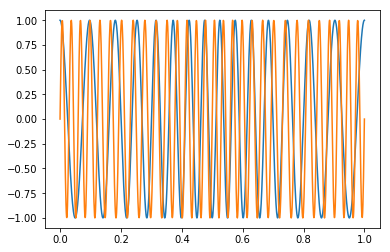

In [4]:
plt.figure()
plt.plot(x,sx[0,:])
plt.plot(x,sx[1,:])
plt.show()

Here the signal $f$ is composed of two IMFs $f = s_1 + s_2$ where 
\begin{equation} s_1 = \cos(30 \pi x - 5 \sin(2 \pi x)) \end{equation} 
and
\begin{equation} s_2 = \sin(60 \pi x + 2 \sin(4 \pi x))\end{equation} 

The initial guesses for this cases run over $f \in [5,45]$

In [5]:
f = cos(30*pi*x-5*sin(2*pi*x)) + sin(60*pi*x+2*sin(4*pi*x))
s1 = cos(15*2*pi*x-5*sin(2*pi*x)) 
s2 = sin(30*2*pi*x+2*sin(4*pi*x))

freq_guess1_vals = np.arange(5,45,3)
freq_guess2_vals = np.arange(5,45,3)

grid = np.zeros((len(freq_guess1_vals),len(freq_guess2_vals)))

for i,freq_guess1 in enumerate(log_progress(freq_guess1_vals)):
    θ1 = freq_guess1*2*pi*x # Initial guess for \theta
    IMF1 = np.array(eng.Decompose_MP_periodic_sym(mat_array(f[:,np.newaxis]),mat_array(θ1[:,np.newaxis]))).flatten()
    residual = f - IMF1 # First residual value
    
    for j,freq_guess2 in enumerate(freq_guess2_vals):
        θ2 = freq_guess2*2*pi*x
        IMF2 = np.array(eng.Decompose_MP_periodic_sym(mat_array(residual[:,np.newaxis]),mat_array(θ2[:,np.newaxis]))).flatten()
        
        residual2 = residual - IMF2
        
        # Fill in grid
        # This is how we compute the "error" in our result
        # Note that we want the colums to be the 1st guess (the x-axis)
        # and the rows to be the 2nd guess (y-axis)
        grid[j,i] = np.linalg.norm(residual2)

VBox(children=(HTML(value=''), IntProgress(value=0, max=14)))

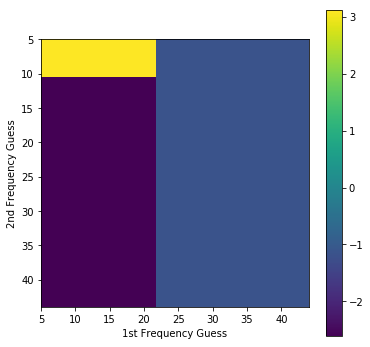

In [6]:
# Plot the different regions of errors
plt.figure(figsize=(6,6))
plt.imshow(np.log(grid),extent=[min(freq_guess1_vals),max(freq_guess1_vals),
                        max(freq_guess2_vals),min(freq_guess2_vals)])
plt.xlabel('1st Frequency Guess')
plt.ylabel('2nd Frequency Guess')



plt.colorbar()
plt.show()

Here are plots of results from the 3 different regions. Note that the matrix above is not symmetric. In otherwords, the order in which the frequencies are guessed does matter!

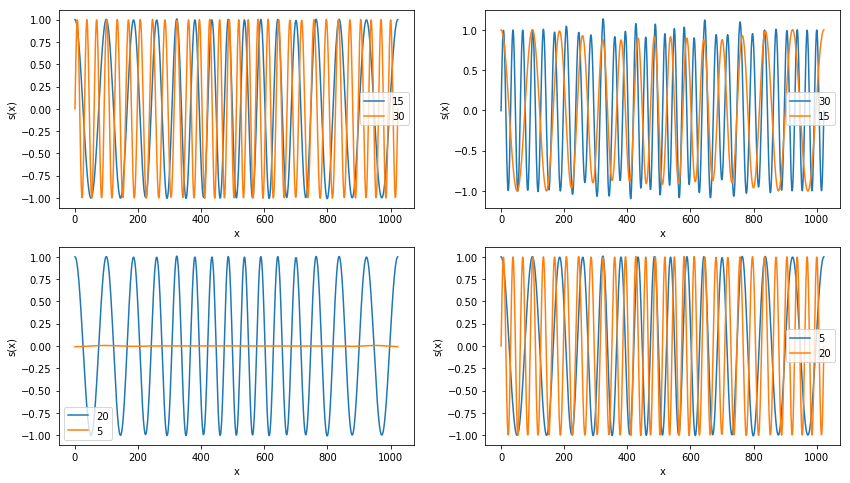

In [7]:
freq_region_1 = (15,30)
freq_region_2 = (30,15)
freq_region_3 = (20,5)
freq_region_4 = (5,20)
freqs = [freq_region_1,freq_region_2,freq_region_3,freq_region_4]


plt.figure(figsize=(14,8))
for i,(freq_guess1,freq_guess2) in enumerate(freqs):
    θ1 = freq_guess1*2*pi*x # Initial guess for \theta
    IMF1 = np.array(eng.Decompose_MP_periodic_sym(mat_array(f[:,np.newaxis]),mat_array(θ1[:,np.newaxis]))).flatten()
    residual = f - IMF1 # First residual value
    
    θ2 = freq_guess2*2*pi*x
    IMF2 = np.array(eng.Decompose_MP_periodic_sym(mat_array(residual[:,np.newaxis]),mat_array(θ2[:,np.newaxis]))).flatten()
        
    residual2 = residual - IMF2
    plt.subplot(2,2,i+1)
    plt.plot(IMF1,label=str(freq_guess1))
    plt.plot(IMF2,label=str(freq_guess2))
    plt.xlabel('x')
    plt.ylabel('s(x)')
    plt.legend()
plt.show()

Here I do a similar test using my spatiotemporal algorithm. 

In [ ]:
ϕ = 0.7
A = np.array([[sin(ϕ),cos(ϕ)],
             [cos(ϕ),-sin(ϕ)]])

s = np.vstack((s1,s2))
f = A.dot(s)

freq_guess1_vals = np.arange(5,45,5)
freq_guess2_vals = np.arange(5,45,5)

grid = np.zeros((len(freq_guess1_vals),len(freq_guess2_vals)))

for i,freq_guess1 in enumerate(log_progress(freq_guess1_vals)):
    for j,freq_guess2 in enumerate(freq_guess2_vals):
        θ1 = freq_guess1*2*pi*x # Initial guess for \theta
        θ2 = freq_guess2*2*pi*x
        guess = np.vstack((θ1,θ2))
        ax,sx,cart = map(np.array,(eng.spatiotemporalbig2(mat_array(f),mat_array(guess),nargout=3)))
        Ax, Sx = map(np.array,eng.mysort(mat_array(cart),mat_array(sx),nargout=2))

        # Fill in grid
        # This is how we compute the "error" in our result
        # Note that we want the colums to be the 1st guess (the x-axis)
        # and the rows to be the 2nd guess (y-axis)
        grid[j,i] = np.linalg.norm(Sx-s)

VBox(children=(HTML(value=''), IntProgress(value=0, max=8)))

The error here is very small $1 \times 10^{-9}$. Consequently, this algorithm for this 

In [ ]:
plt.figure(figsize=(6,6))
plt.imshow(grid,extent=[min(freq_guess1_vals),max(freq_guess1_vals),
                        max(freq_guess2_vals),min(freq_guess2_vals)])
plt.xlabel('1st Frequency Guess')
plt.ylabel('2nd Frequency Guess')



plt.colorbar()
plt.show()